In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vgg16-models-mnist-fashion-mnist/vgg16_fashion-mnist_model.pth
/kaggle/input/vgg16-models-mnist-fashion-mnist/vgg16_mnist_model.pth


In [2]:
# Import libraries and packages
from PIL import Image
import matplotlib.pyplot as plt  # plot graphs and images

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
from torchvision import models

### Use GPU-T4

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## PGD (Projected Gradient Descent) Attack
An intuitive extension of FGSM (single large step in the direction to increase loss) is to iteratively take multiple small steps while adjusting the direction after each step. The Basic Iterative Method (BIM) [1] does exactly that, and iteratively computes the following:
<br/>
$ I^{i+1}_{\rho} = Clip_{\epsilon} \{I^i_{\rho} + \alpha \; sign(\nabla J(\theta, I^i_{\rho} ,l))\}$            
<br/>
where $I^i_{\rho}$ denotes the perturbed image at the $i^{th}$ iteration, $Clip_{\epsilon}\{.\}$ clips (the values of the pixels of) the image in its argument at $\epsilon$ and $\alpha$ determines the step size (normally, $\alpha$ = 1). The BIM algorithm starts with $I^0_{\rho} = I_c$ and runs for the number of iterations determined by the formula $\lfloor min(\epsilon + 4, 1.25\epsilon)\rfloor$.
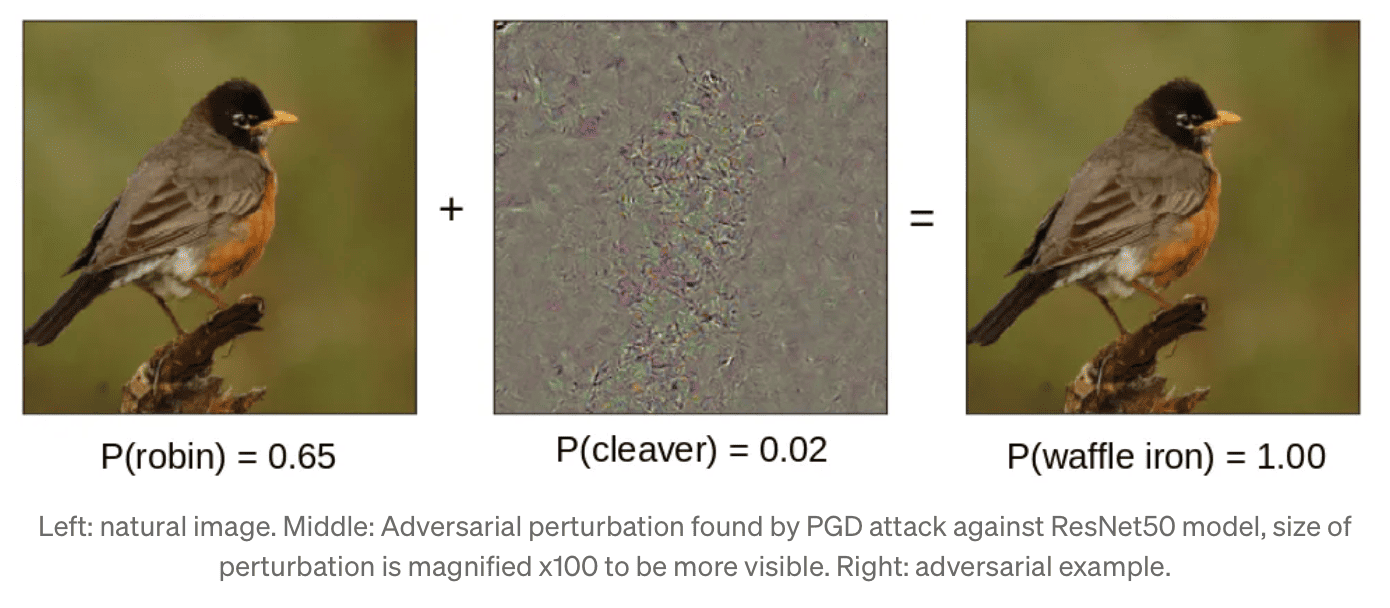
Source : https://towardsdatascience.com/know-your-enemy-7f7c5038bdf3

PGD adversarial attack was originally proposed by Madry et al. [2] as the most strongest “first-order adversarial” attack. Actually PGD is a well-known optimization technique projecting gradients in a ball. PGD is basically the same as BIM, described above, except that PGD starts at a random point in the ball and perform random restarts.
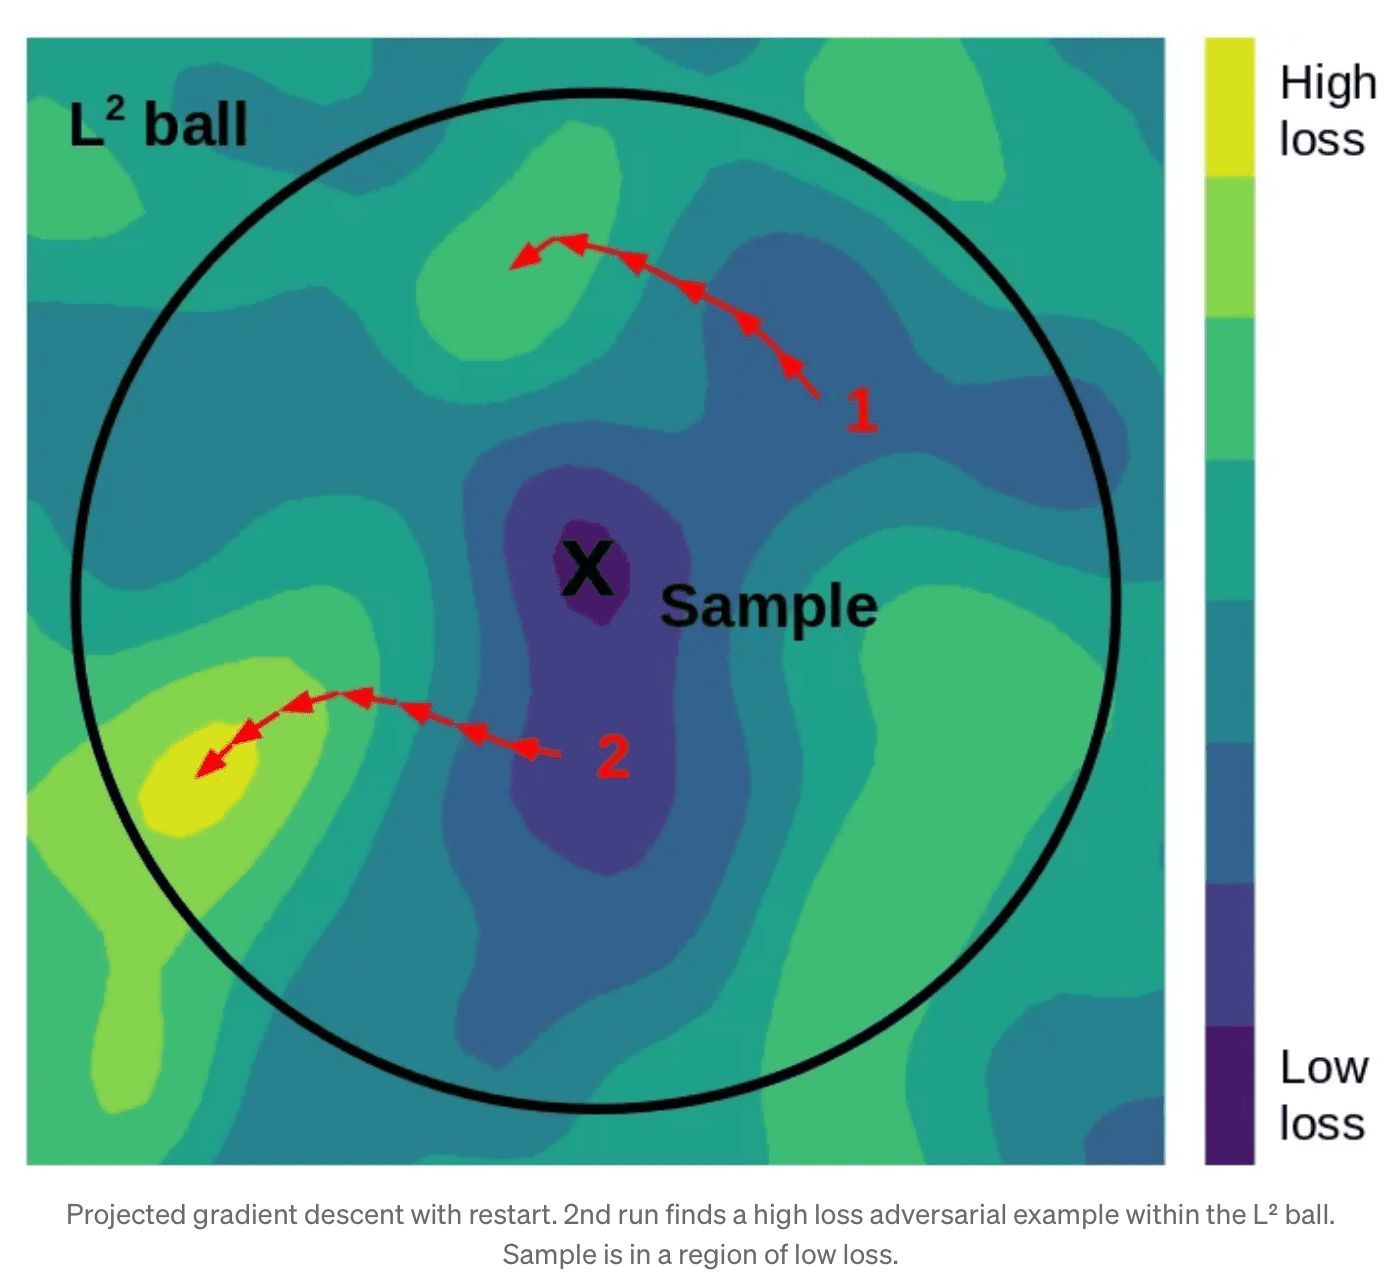
The 'l' parameter in the given equation is emphasized, because adversarial attacks can trick the ML classifier either as targeted or untargeted. In the targeted case, the malicious attacker forces the classifier to produce a certain class of output. On the other hand, the classifier is expected to give a misclassification where the label of the output class is not important in the untargeted case.

References :
<br/>[1] - Adversarial examples in the physical world - Alexey Kurakin, Ian Goodfellow, Samy Bengio (https://arxiv.org/abs/1607.02533)
<br/>[2] - A. Madry, A. Makelov, L. Schmidt, D. Tsipras and A. Vladu, "Towards deep learning models resistant to adversarial attacks", arXiv preprint, 2017.


In [4]:
def pgd_linf(model, imgs, labels, epsilon, alpha, num_iter, flag=0):
    """ Construct PGD adversarial examples on the examples X"""
    delta = torch.zeros_like(imgs, requires_grad=True)
    if flag == 1:
        num_iter = 1
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(imgs + delta), labels)
        loss.backward()
        delta.data = (delta + alpha * delta.grad.detach().sign()).clamp(-epsilon, epsilon)
        delta.grad.zero_()
        new_preds = model(imgs + delta).argmax(axis=1)
    return (imgs + delta).detach(), new_preds

In [5]:
# Storing different values of epsilon - determining the degree of attack
epsilons = [0.00, 0.05, 0.10, 0.15, 0.20, 0.30]

## VGG-16 (Loading pre-trained model)

In [6]:
class VGGBlock(nn.Module):
    def __init__(self, in_channels, out_channels, batch_norm=False):
        super().__init__()
        conv2_params = {'kernel_size': (3, 3),
                        'stride'     : (1, 1),
                        'padding'   : 1}

        noop = lambda x : x
        self._batch_norm = batch_norm

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels , **conv2_params)
        self.bn1 = nn.BatchNorm2d(out_channels) if batch_norm else noop

        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, **conv2_params)
        self.bn2 = nn.BatchNorm2d(out_channels) if batch_norm else noop

        self.max_pooling = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    @property
    def batch_norm(self):
        return self._batch_norm

    def forward(self,x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        x = self.max_pooling(x)

        return x
    

class VGG16(nn.Module):
    def __init__(self, input_size, num_classes=10, batch_norm=False):
        super(VGG16, self).__init__()

        self.in_channels, self.in_width, self.in_height = input_size

        self.block_1 = VGGBlock(self.in_channels, 64, batch_norm=batch_norm)
        self.block_2 = VGGBlock(64, 128, batch_norm=batch_norm)
        self.block_3 = VGGBlock(128, 256, batch_norm=batch_norm)
        self.block_4 = VGGBlock(256,512, batch_norm=batch_norm)

        self.classifier = nn.Sequential(
                nn.Linear(2048, 4096),
                nn.ReLU(True),
                nn.Dropout(p=0.65),
                nn.Linear(4096, 4096),
                nn.ReLU(True),
                nn.Dropout(p=0.65),
                nn.Linear(4096, num_classes) 
            )

    @property
    def input_size(self):
          return self.in_channels, self.in_width, self.in_height

    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x

In [7]:
model = VGG16((1,32,32), batch_norm=True)
model.to(device)

VGG16(
  (block_1): VGGBlock(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (max_pooling): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): VGGBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (max_pooling): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block_3): VGGBlock(
    (conv1): Conv2d(128,

## Load the MNIST Dataset

In [8]:
transform=transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.MNIST(root='/kaggle/temp/', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 99679236.73it/s]


Extracting /kaggle/temp/MNIST/raw/train-images-idx3-ubyte.gz to /kaggle/temp/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 56526222.04it/s]


Extracting /kaggle/temp/MNIST/raw/train-labels-idx1-ubyte.gz to /kaggle/temp/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25228877.95it/s]


Extracting /kaggle/temp/MNIST/raw/t10k-images-idx3-ubyte.gz to /kaggle/temp/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8051787.31it/s]


Extracting /kaggle/temp/MNIST/raw/t10k-labels-idx1-ubyte.gz to /kaggle/temp/MNIST/raw



In [9]:
# Load the saved checkpoint 
model.load_state_dict(torch.load('/kaggle/input/vgg16-models-mnist-fashion-mnist/vgg16_mnist_model.pth'))

<All keys matched successfully>

In [10]:
accs = []
for eps in epsilons:
    flag = 0
    if eps == 0:
        flag = 1
    correct, total = 0, 0
    for i, (imgs, labels) in enumerate(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        imgs, labels = Variable(imgs, requires_grad=True), Variable(labels)

        _, y_preds = pgd_linf(model, imgs, labels, eps, alpha=1e-2, num_iter=40, flag=flag)
        
        correct += (y_preds==labels).sum().item()
        total += labels.size(0)

    print("Epsilon: {}, Test Accuracy: {:.4f}".format(eps, correct / total))
    accs.append((correct / total))

Epsilon: 0.0, Test Accuracy: 0.9922
Epsilon: 0.05, Test Accuracy: 0.6130
Epsilon: 0.1, Test Accuracy: 0.1723
Epsilon: 0.15, Test Accuracy: 0.0418
Epsilon: 0.2, Test Accuracy: 0.0181
Epsilon: 0.3, Test Accuracy: 0.0118


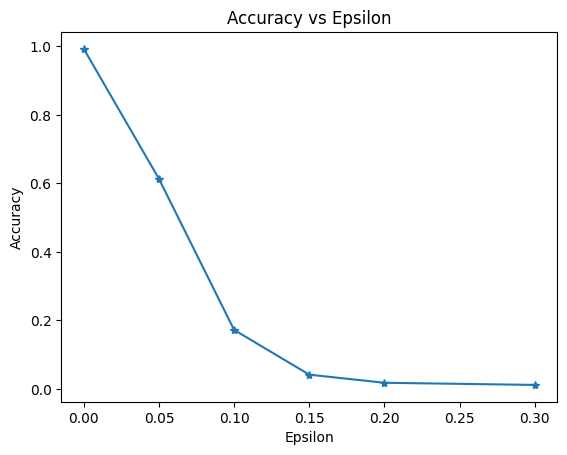

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1)  # create figure & 1 axis
ax.plot(epsilons, accs, "*-")
ax.set_title("Accuracy vs Epsilon")
ax.set_xlabel("Epsilon")
ax.set_ylabel("Accuracy")
fig.show()

In [12]:
def to_numpy_array(tensor):
    '''Convert torch.Tensor to np.ndarray'''
    tensor_ = tensor.cpu()
    tensor_ = tensor_.squeeze(0)
    tensor_ = tensor_.detach().numpy()
    return tensor_

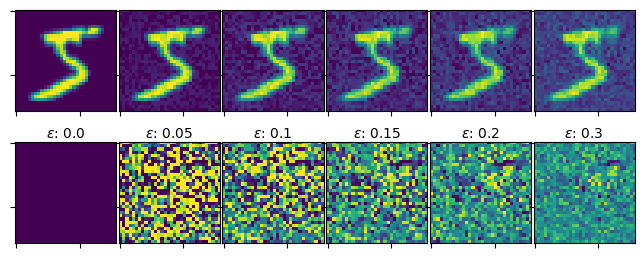

In [13]:
for _, (imgs, labels) in enumerate(train_loader):
    imgs, labels = imgs.to(device), labels.to(device)
    imgs, labels = Variable(imgs, requires_grad=True), Variable(labels)

    f = plt.figure(figsize=(8, 4))
    gs = f.add_gridspec(2, len(epsilons))
    gs.update(wspace=0.025, hspace=-0.25) 

    for i in range(len(epsilons)):
        eps = epsilons[i]
        ax1 = f.add_subplot(gs[0, i])
        ax2 = f.add_subplot(gs[1, i])
        imgs, labels = imgs.to(device), labels.to(device)
        imgs, labels = Variable(imgs, requires_grad=True), Variable(labels)

        adv_imgs, _ = pgd_linf(model, imgs, labels, epsilon=eps, alpha=1e-2, num_iter=40)
        
        img, adv_img = imgs[0], adv_imgs[0]
        img, adv_img = to_numpy_array(img), to_numpy_array(adv_img)
        noise = adv_img - img

        ax1.imshow(adv_img)
        ax1.set_xlabel(f"$\epsilon$: {eps}")
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

        ax2.imshow(noise)
        ax2.set_xticklabels([])
        ax2.set_yticklabels([])

    f.show()
    break

## Load Fashion-MNIST Dataset


In [14]:
transform=transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.FashionMNIST(root='/kaggle/temp/', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=False)

100%|██████████| 26421880/26421880 [00:01<00:00, 17902187.47it/s]


Extracting /kaggle/temp/FashionMNIST/raw/train-images-idx3-ubyte.gz to /kaggle/temp/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 270020.95it/s]


Extracting /kaggle/temp/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /kaggle/temp/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5052322.05it/s]


Extracting /kaggle/temp/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /kaggle/temp/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 9176488.31it/s]

Extracting /kaggle/temp/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /kaggle/temp/FashionMNIST/raw



In [15]:
# Load the saved checkpoint 
model = VGG16((1,32,32), batch_norm=True)
model.to(device)
model.load_state_dict(torch.load('/kaggle/input/vgg16-models-mnist-fashion-mnist/vgg16_fashion-mnist_model.pth'))

<All keys matched successfully>

In [16]:
accs = []
for eps in epsilons:
    flag = 0
    if eps == 0:
        flag = 1
    correct, total = 0, 0
    for i, (imgs, labels) in enumerate(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        imgs, labels = Variable(imgs, requires_grad=True), Variable(labels)

        _, y_preds = pgd_linf(model, imgs, labels, eps, alpha=1e-2, num_iter=7, flag=flag)
        
        correct += (y_preds==labels).sum().item()
        total += labels.size(0)

    print("Epsilon: {}, Test Accuracy: {:.4f}".format(eps, correct / total))
    accs.append((correct / total))

Epsilon: 0.0, Test Accuracy: 0.9606
Epsilon: 0.05, Test Accuracy: 0.3150
Epsilon: 0.1, Test Accuracy: 0.2962
Epsilon: 0.15, Test Accuracy: 0.2942
Epsilon: 0.2, Test Accuracy: 0.2950
Epsilon: 0.3, Test Accuracy: 0.2954


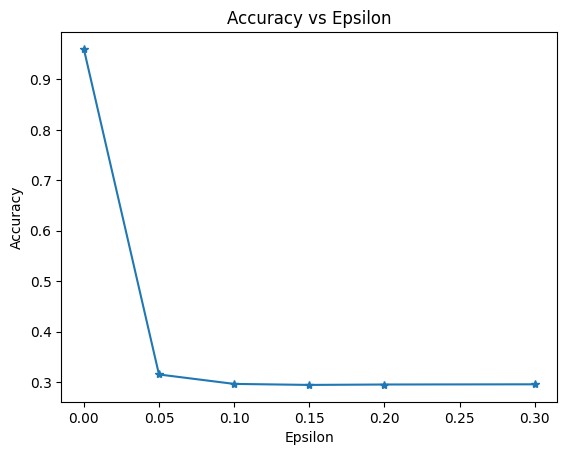

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1)  # create figure & 1 axis
ax.plot(epsilons, accs, "*-")
ax.set_title("Accuracy vs Epsilon")
ax.set_xlabel("Epsilon")
ax.set_ylabel("Accuracy")
fig.show()

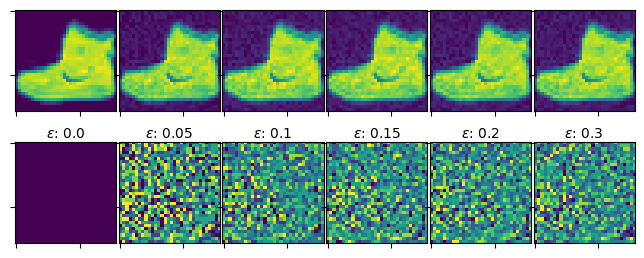

In [18]:
for _, (imgs, labels) in enumerate(train_loader):
    imgs, labels = imgs.to(device), labels.to(device)
    imgs, labels = Variable(imgs, requires_grad=True), Variable(labels)

    f = plt.figure(figsize=(8, 4))
    gs = f.add_gridspec(2, len(epsilons))
    gs.update(wspace=0.025, hspace=-0.25) 

    for i in range(len(epsilons)):
        eps = epsilons[i]
        ax1 = f.add_subplot(gs[0, i])
        ax2 = f.add_subplot(gs[1, i])
        imgs, labels = imgs.to(device), labels.to(device)
        imgs, labels = Variable(imgs, requires_grad=True), Variable(labels)

        adv_imgs, _ = pgd_linf(model, imgs, labels, epsilon=eps, alpha=1e-2, num_iter=7)
        
        img, adv_img = imgs[0], adv_imgs[0]
        img, adv_img = to_numpy_array(img), to_numpy_array(adv_img)
        noise = adv_img - img

        ax1.imshow(adv_img)
        ax1.set_xlabel(f"$\epsilon$: {eps}")
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

        ax2.imshow(noise)
        ax2.set_xticklabels([])
        ax2.set_yticklabels([])

    f.show()
    break